In [7]:
import thesis_library
from multiprocessing import Pool
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Previous day values

### Best theta on day 1

Зафитим кривую на ставки ЦБ на первый день. Дальше будем использовать веса предыдущего дня.

In [2]:
cbr_maturities = np.array([0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 10.00, 15.00, 20.00, 30.00])
cbr_rates_040116 = np.array([8.77, 9.34, 9.70, 9.91, 10.07, 9.97, 9.80, 9.67, 9.51, 9.39, 9.35, 9.34])

In [7]:
def fit_curve(theta):
    return ((cbr_rates_040116 - thesis_library.nss(cbr_maturities, theta))**2).sum()

In [11]:
theta0 = np.array([10, 10, 10, 10, 10, 10])

best_theta = minimize(fit_curve, theta0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True, 'maxiter': 10000})

Optimization terminated successfully.
         Current function value: 0.003174
         Iterations: 2134
         Function evaluations: 3327


In [12]:
best_theta.x

array([ 0.53856818,  1.47032643,  9.19966626, -1.41323064,  3.39936123,
        1.49109947])

## BFGS

In [20]:
thetas = np.zeros([len(thesis_library.dates), 6])

for i in range(4):
    if i != 0:        
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'BFGS', theta0 = thetas[i - 1])        
    else:
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'BFGS', theta0 = best_theta.x)

thetas = pd.DataFrame(thetas, index = thesis_library.dates, columns = ['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'])
thetas.to_csv('C:/Users/1/Desktop/Comparing-numerical-methods-for-term-structure-fitting/Thetas/bfgs_recurrent.csv')

## Nelder-Mead

In [20]:
thetas = np.zeros([len(thesis_library.dates), 6])

for i in range(4):
    if i != 0:        
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'nelder-mead', theta0 = thetas[i - 1])        
    else:
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'nelder-mead', theta0 = best_theta.x)

thetas = pd.DataFrame(thetas, index = thesis_library.dates, columns = ['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'])
thetas.to_csv('C:/Users/1/Desktop/Comparing-numerical-methods-for-term-structure-fitting/Thetas/nelder_mead_recurrent.csv')

## Powell

In [20]:
thetas = np.zeros([len(thesis_library.dates), 6])

for i in range(4):
    if i != 0:        
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'powell', theta0 = thetas[i - 1])        
    else:
        thetas[i] = thesis_library.optimize_on_day_with_starting_values(i, 'powell', theta0 = best_theta.x)

thetas = pd.DataFrame(thetas, index = thesis_library.dates, columns = ['tau1', 'tau2', 'beta0', 'beta1', 'beta2', 'beta3'])
thetas.to_csv('C:/Users/1/Desktop/Comparing-numerical-methods-for-term-structure-fitting/Thetas/powell_recurrent.csv')

# Random starting values

### Values generated

In [4]:
np.random.seed(1)

rand_thetas = [np.concatenate([np.array([i]), np.random.uniform(low=0, high=30, size = 2), 
                              np.random.uniform(low=0, high=100, size = 2), np.random.uniform(low=-100, high=100, size = 2)
                              ]) for i in range(1, 9)]

In [10]:
rand_thetas[0][1:]

array([ 1.25106601e+01,  2.16097348e+01,  1.14374817e-02,  3.02332573e+01,
       -7.06488218e+01, -8.15322810e+01])

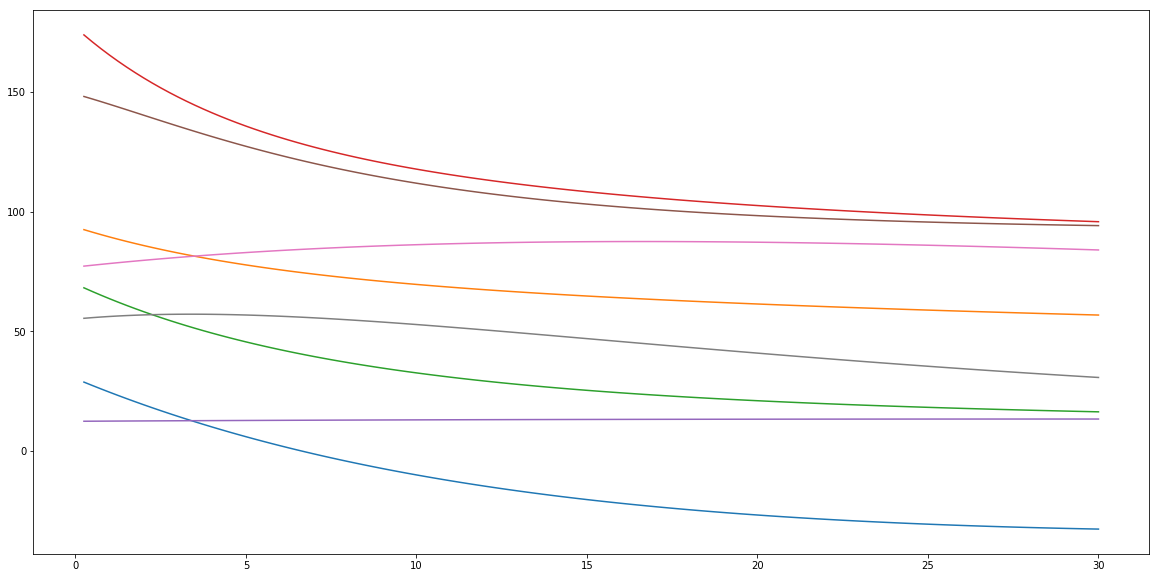

In [13]:
maturities = np.linspace(0, 30, 121)

plt.figure(figsize=(20, 10))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[0][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[1][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[2][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[3][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[4][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[5][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[6][1:]))
plt.plot(maturities, thesis_library.nss(maturities, theta = rand_thetas[7][1:]));

## BFGS

### 1 - 4

In [4]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_bfgs, rand_thetas[:4])

Wall time: 55min 18s


### 5 - 8

In [ ]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_bfgs, rand_thetas[4:])

Wall time: 1h 17min 37s


## Nelder-Mead

### 1 - 4

In [3]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_nelder_mead, rand_thetas[:4])

Wall time: 54min 22s


### 5 - 8

In [4]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_nelder_mead, rand_thetas[4:])

Wall time: 1h 13min 16s


## Powell

### 1 - 4

In [5]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_powell, rand_thetas[:4])

Wall time: 51min 33s


### 5 - 8

In [6]:
%%time

with Pool(processes=4) as pool: 

    pool.map(thesis_library.optimize_ss_powell, rand_thetas[4:])

Wall time: 1h 12min 36s


# Diebold, Li starting values

# PSO

In [ ]:
intervals = [np.array([0, 62]), np.array([62, 126]), np.array([126, 189]), np.array([189, 251])]

In [ ]:
%%time

with Pool(processes=4) as pool: 

    pool.map(pso_multithread, intervals)

# Flat 7%, tau 3 and 7